<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from keras.preprocessing.sequence import TimeseriesGenerator

In [62]:
ticker = "QQQ"
#features = ['Close','High','Low','Open']
features = ['Close']
look_back = 5 #  number of past days we want to use to predict the future.
max_data_size = 730 # 2 years
split_percent = 0.90 # use 90 of the data  for train
zoom = 180 # last 180 days see in chart

In [63]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=3F4URDEKOPLFH25T'
print(url)
stock_api_response = pd.read_json(url)
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);
#print(list(stock_api_data.items()))
data = []
split_coefficient = 1

for key, value in stock_api_data.items():
  date = key
  open = float(value.get('1. open'))
  high = float(value.get('2. high'))
  low = float(value.get('3. low'))
  close = float(value.get('4. close'))
  adjusted_close = float(value.get('5. adjusted close'))
  volume = int(value.get('6. volume'))
  divident = float(value.get('7. dividend amount'))

  if float(value.get('8. split coefficient')) > 1:
    split_coefficient = float(value.get('8. split coefficient'))
    
  open = open / split_coefficient
  high = high /split_coefficient
  close = close / split_coefficient
  low = low / split_coefficient

  data.append([
      date,
      open,
      high,
      low,
      close,
      volume,
      divident
      ])

last_data =  str(data[0][0])
print(data[0])
if max_data_size < len(data):
  data = np.flip(data[:max_data_size],axis=0)
else:
  data = np.flip(data,axis=0)
print('data size:',len(data), 'max_data_size:', max_data_size)


https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=QQQ&outputsize=full&apikey=3F4URDEKOPLFH25T
['2021-10-22', 375.98, 376.97, 372.385, 374.1, 36275822, 0.0]
data size: 730 max_data_size: 730


In [64]:
df = pd.DataFrame(data,columns=['Date','Open','High','Low','Close','Volume','Divident'])

df['50MA'] = df['Close'].rolling(50).mean()
df['100MA'] = df['Close'].rolling(100).mean()
df['200MA'] = df['Close'].rolling(200).mean()

split = int(split_percent*len(data))
if len(data) - split < look_back:
  split = look_back
split
#df.head()

df_train = df.iloc[:split]
df_test = df.iloc[split:]

In [65]:
def create_LSTM_input(df_with_features,nr_of_features,n_past=6):
  #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  #scaler = StandardScaler()
  scaler = scaler.fit(df_with_features)
  df_with_features_scaled = scaler.transform(df_with_features)

  #As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
  #In this example, the n_features is 5. We will make timesteps = look_back (past days data used for training). 



  #Empty lists to be populated using formatted training data
  trainX = []
  trainY = []

  n_future = 1   # Number of days we want to look into the future based on the past days.


  #Reformat input data into a shape: (n_samples x timesteps x n_features)
  #In my example, my df_with_features has a shape (12823, 4)
  #12823 refers to the number of data points and 5 refers to the columns (multi-variables).
  for i in range(look_back, len(df_with_features_scaled) - n_future +1):
      trainX.append(df_with_features_scaled[i - look_back:i, 0:nr_of_features])
      trainY.append(df_with_features_scaled[i + n_future - 1:i + n_future, 0])

  trainX, trainY = np.array(trainX), np.array(trainY)

  print('LSTM_X shape == {}.'.format(trainX.shape))
  print('LSTM_Y shape == {}.'.format(trainY.shape))
  return trainX, trainY, df_with_features_scaled, scaler

In [66]:
#Variables for training
#Date,Volume adn Divident columns are not used in training. 
df_for_training = df_train[features].astype(float)
print(df_for_training.head())
print(df_for_training.shape)
trainX, trainY, df_for_training_scaled, scaler = create_LSTM_input(df_for_training,len(features),look_back)

    Close
0  168.15
1  169.37
2  172.33
3  165.72
4  166.89
(657, 1)
LSTM_X shape == (652, 5, 1).
LSTM_Y shape == (652, 1).


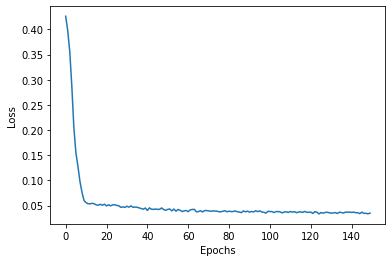

In [67]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

model = Sequential()
model.add(LSTM(units=50, activation='tanh', input_shape=(look_back, len(features)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(1))


#model = Sequential()
#model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(LSTM(32, activation='relu', return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Dense(trainY.shape[1]))

model.compile(
    loss=MAE,
    optimizer=Adam(learning_rate=0.0001),
    metrics=["mae"]
)
  
#model.summary()


# fit the model
modelo = model.fit(trainX, trainY, epochs=150, verbose=0)

plt.plot(modelo.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [68]:
df_for_test = df_test[features].astype(float)
testX, testY, df_for_test_scaled, test_scaler = create_LSTM_input(df_for_test,len(features),look_back)

LSTM_X shape == (68, 5, 1).
LSTM_Y shape == (68, 1).


In [69]:
#Make prediction
prediction = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, len(features), axis=-1)
y_pred_future = test_scaler.inverse_transform(prediction_copies)
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

print('y_pred_future shape:',y_pred_future.shape)

for x in range(4):
  print('pred close:',x,  y_pred_future[x].astype(np.float), df_test['Close'].iloc[x])

pred_prices = y_pred_future[:,0]
#pred_volumes = y_pred_future[:,1]
print(pred_prices)

y_pred_future shape: (68, 1)
pred close: 0 [ 362.05] 362.42
pred close: 1 [ 361.06] 363.07
pred close: 2 [ 358.84] 360.52
pred close: 3 [ 357.44] 357.6
[ 362.05  361.06  358.84  357.44  357.86  361.30  363.95  366.17  367.78
  366.96  365.38  365.99  365.90  365.40  366.28  367.77  368.46  369.08
  368.19  367.98  367.17  367.41  368.18  368.15  366.91  364.91  364.69
  367.59  371.14  373.99  374.57  374.88  375.39  378.10  379.91  379.98
  380.36  380.56  380.90  380.47  379.17  377.80  376.48  376.41  376.34
  376.55  374.35  370.28  367.27  368.99  371.28  371.87  369.53  364.90
  359.45  358.73  357.93  357.74  356.02  359.28  360.87  361.49  359.91
  359.11  360.58  364.58  369.20  371.79]


In [77]:
def predict(data_to_predict, num_prediction, model):
    #print(data_to_predict.shape)
    prediction_list = data_to_predict[-look_back:]
    print("prediction_list:",prediction_list)
    
    for _ in range(num_prediction):
      x = prediction_list[-look_back:]
      x = x.reshape((1, look_back, len(features)))
      out = model.predict(x)[0][0]
      prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(last_date,num_prediction):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq=us_bd).tolist()
    return prediction_dates

num_prediction = 10 #  days to predict
forecast_scaled = predict(testX.reshape((-1)), num_prediction, model)
print("forecast_scaled:",forecast_scaled)

forecast_dates = predict_dates(df['Date'].values[-1],num_prediction)

forecast = test_scaler.inverse_transform(forecast_scaled.reshape((-1,1)))
forecast_prices = forecast.reshape((-1))
print("forecast:",forecast[:5],"mean:", np.mean(forecast))
print("forecast dstes:",forecast_dates[:5])

prediction_list: [ 0.55  0.68  0.77  0.76  0.84]
forecast_scaled: [ 0.84  0.65  0.73  0.77  0.77  0.77  0.71  0.76  0.77  0.76  0.75]
forecast: [[ 377.27]
 [ 371.79]
 [ 374.28]
 [ 375.47]
 [ 375.25]] mean: 374.8279449990663
forecast dstes: [Timestamp('2021-10-22 00:00:00', freq='C'), Timestamp('2021-10-25 00:00:00', freq='C'), Timestamp('2021-10-26 00:00:00', freq='C'), Timestamp('2021-10-27 00:00:00', freq='C'), Timestamp('2021-10-28 00:00:00', freq='C')]


In [71]:
trace1 = go.Candlestick(
    x = df_train['Date'],
    open = df_train['Open'],
    high = df_train['High'],
    low = df_train['Low'],
    close = df_train['Close'],
    name = 'Train'
)

trace2 = go.Candlestick(
    x = df_test['Date'],
    open = df_test['Open'],
    high = df_test['High'],
    low = df_test['Low'],
    close = df_test['Close'],
    increasing={'line': {'color': 'lightblue'}},
    decreasing={'line': {'color': 'purple'}},    
    name ='Test'
)

trace3 = go.Scatter(
    x = df_test['Date'],
    y = pred_prices,
    name ='Test'
)

trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast_prices,
    name ='Forecast'
)

trace5 = go.Scatter(
    x = df['Date'],
    y = df['50MA'],
    mode='lines',
    name ='50MA'
)

trace6 = go.Scatter(
    x = df['Date'],
    y = df['100MA'],
    mode='lines',
    name ='100MA'
)

trace7 = go.Scatter(
    x = df['Date'],
    y = df['200MA'],
    mode='lines',
    name ='200MA'
)

layout = go.Layout(
    title = ticker + ' Date:' + last_data + ' Open:' + str(data[-1][1]) + ' High:' + str(data[-1][2]) + ' Low:' + str(data[-1][3]) + ' Close:' + str(data[-1][4]),
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "Close Price ($)"},
    height = 450
)

fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7], layout=layout)

fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
fig.update_layout(xaxis_rangeslider_visible=False)
config = dict({'scrollZoom': True})
fig.show(config=config)

fig1 = px.bar(
    x=df['Date'], 
    y=df['Volume'], 
    height=250, 
    labels={"x": "Dates","y": "Volume"},
    title=ticker)
fig1.show()